### Imports

In [1]:
# --- Core and Utility Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from datetime import datetime

# --- Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, f_regression

# --- Models ---
# Classification

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

### We used the final cleaned and winsorized data.

In [2]:
df=pd.read_csv(r"D:/python/Instacart_cleaned/instacart_cleaned.csv")
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_cohort
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0,Low
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0,Low
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0,Low
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0,Low
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0,Low


In [3]:
print(df.columns)


Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'user_cohort'],
      dtype='object')


In [4]:
# We don't have "order_date" , so we need to reconstruct a time series and engineer features for daily or weekly demand forecasting


# Reconstruct Synthetic 'order_date'

# Sort by user and order sequence
df = df.sort_values(by=["user_id", "order_number"])

# Fill missing gaps with 0
df["days_since_prior_order"] = df["days_since_prior_order"].fillna(0)

# Create cumulative day count per user
df["relative_day"] = df.groupby("user_id")["days_since_prior_order"].cumsum()

# Convert to synthetic date starting from a fixed point
df["order_date"] = pd.to_datetime("2020-01-01") + pd.to_timedelta(df["relative_day"], unit="D")

df = df.reset_index(drop=True)



In [5]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_cohort,relative_day,order_date
0,2539329,196,1,0,Soda,77,7,soft drinks,beverages,1,prior,1,2,8,0.0,Low,0.0,2020-01-01
1,2539329,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs,1,prior,1,2,8,0.0,Low,0.0,2020-01-01
2,2539329,12427,3,0,Original Beef Jerky,23,19,popcorn jerky,snacks,1,prior,1,2,8,0.0,Low,0.0,2020-01-01
3,2539329,26088,4,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks,1,prior,1,2,8,0.0,Low,0.0,2020-01-01
4,2539329,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household,1,prior,1,2,8,0.0,Low,0.0,2020-01-01


In [6]:
# Aggregate Daily Product Demand

# Daily demand per product
daily_demand = df.groupby(["order_date", "product_id"]).size().reset_index(name="demand")

In [24]:
# There are lot of products so we have taken top 10 products from each aisle
# Count product frequency within each aisle
product_counts = df.groupby(["aisle", "product_id"])["order_id"].count().reset_index(name="order_count")

# Rank products within each aisle
product_counts["rank"] = product_counts.groupby("aisle")["order_count"].rank(method="first", ascending=False)

# Filter top 10 per aisle
top10_per_aisle = product_counts[product_counts["rank"] <= 10].copy()


In [8]:
top10_per_aisle = top10_per_aisle.merge(df[["product_id", "product_name"]].drop_duplicates(), on="product_id", how="left")


In [9]:

# Merge with main data
df_top = df[df["product_id"].isin(top10_per_aisle["product_id"])].copy()

In [11]:
#pip install prophet

13:19:24 - cmdstanpy - INFO - Chain [1] start processing
13:19:25 - cmdstanpy - INFO - Chain [1] done processing


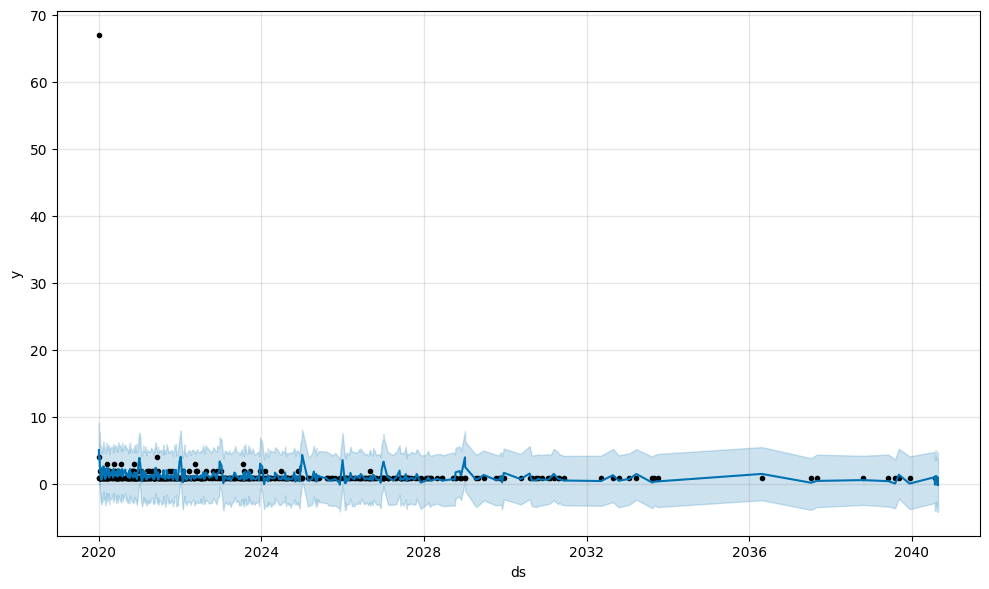

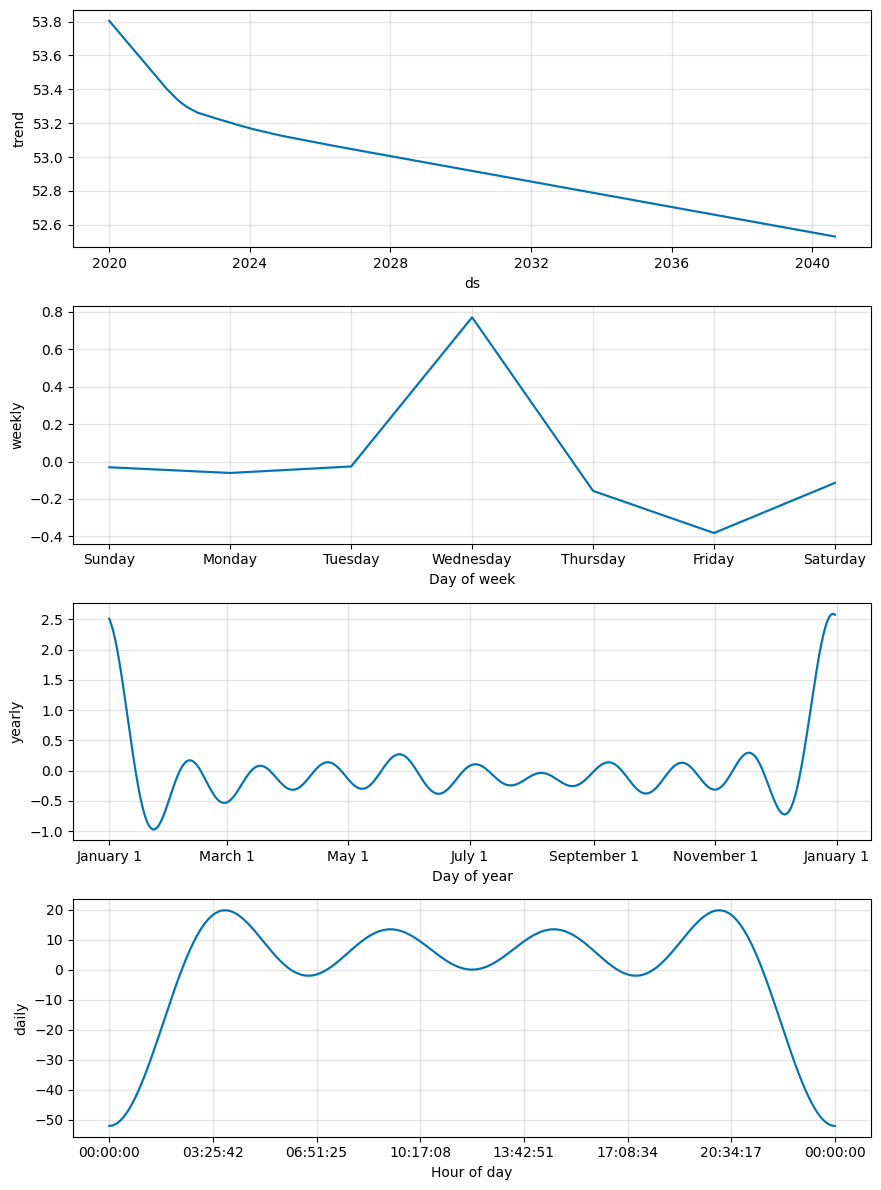

In [12]:
from prophet import Prophet

def forecast_with_prophet(product_id):
    product_demand = df_top[df_top["product_id"] == product_id]
    daily_demand = product_demand.groupby("order_date").size().reset_index(name="y")
    daily_demand.rename(columns={"order_date": "ds"}, inplace=True)

    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(daily_demand)

    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)

    model.plot(forecast)
    model.plot_components(forecast)

# Example: forecast for one product
forecast_with_prophet(product_id=top10_per_aisle["product_id"].iloc[0])


In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

def forecast_with_xgb(product_id):
    product_demand = df_top[df_top["product_id"] == product_id]
    daily_demand = product_demand.groupby("order_date").size().reset_index(name="demand")
    daily_demand = daily_demand.set_index("order_date").resample("D").sum().fillna(0)

    # Create lag features
    for lag in range(1, 8):
        daily_demand[f"lag_{lag}"] = daily_demand["demand"].shift(lag)
    daily_demand["rolling_mean_7"] = daily_demand[[f"lag_{i}" for i in range(1, 8)]].mean(axis=1)
    daily_demand = daily_demand.dropna()

    X = daily_demand.drop(columns=["demand"])
    y = daily_demand["demand"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_test, y_pred

# Example: forecast for one product
y_true, y_pred = forecast_with_xgb(product_id=top10_per_aisle["product_id"].iloc[0])


In [15]:
# Pick the first product from the top 10 list
product_id = top10_per_aisle["product_id"].iloc[0]


In [16]:
y_true, y_pred = forecast_with_xgb(product_id)

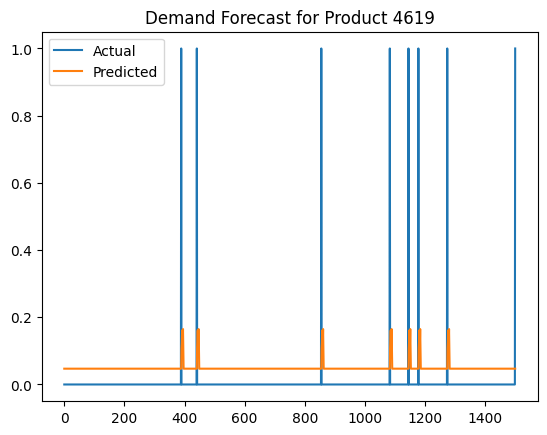

In [17]:
import matplotlib.pyplot as plt

plt.plot(y_true.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title(f"Demand Forecast for Product {product_id}")
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_regression(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"📊 Regression Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R²:   {r2:.4f}")


In [21]:
y_true, y_pred = forecast_with_xgb(product_id)
evaluate_regression(y_true, y_pred)


📊 Regression Evaluation:
RMSE: 0.0866
MAE:  0.0544
R²:   -0.4159
